In [2]:
import boto3
import os
import pandas as pd
import glob
import shutil
from sagemaker import get_execution_role, Session

# Initialize a SageMaker session
sagemaker_session = Session()

# Role and local directory settings
role = "arn:aws:iam::016114370410:role/tf-binding-sites"
local_base_dir = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/jsonl_output"

# List of prefixes to download
prefixes = [
    "AR-log10-22Rv1-2024-11-07-15-31-21",
    "AR-min-max--1-to-1-22Rv1-2024-11-08-12-16-06",
    "AR-min-max-0-to-1-22Rv1-2024-11-08-13-44-29",
    "AR-normal-dist-22Rv1-2024-11-08-15-12-27"
]

# Initialize the S3 client
s3 = boto3.client('s3')

# Specify your S3 bucket name
bucket_name = sagemaker_session.default_bucket()
bucket_name = "tf-binding-sites"

# Dictionary to hold DataFrames
dataframes = {}

# Function to download files from an S3 bucket
def download_from_s3(bucket_name, prefix, local_dir):
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)

    # List objects within the specified prefix
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    # Check if the response contains any contents
    if 'Contents' in response:
        # Iterate over each object
        for obj in response['Contents']:
            key = obj['Key']
            # Skip if it's a folder
            if key.endswith('/'):
                continue
            local_path = os.path.join(local_dir, os.path.basename(key))
            
            # Download the file
            s3.download_file(bucket_name, key, local_path)
            print(f'Downloaded {key} to {local_path}')
            
    else:
        print(f'No files found for prefix: {prefix}')

# Clear the local base directory
if os.path.exists(local_base_dir):
    for item in os.listdir(local_base_dir):
        item_path = os.path.join(local_base_dir, item)
        # Remove files and directories
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

# Download the files for each prefix and save to local_base_dir/prefix
for prefix in prefixes:
    
    json_dir = os.path.join(local_base_dir, prefix)  # This is where the files will be saved
    download_from_s3(bucket_name, f'inference/output/{prefix}/', json_dir)
    json_files = glob.glob(f"{json_dir}/*.jsonl.gz.out")
    dfs = [pd.read_json(file) for file in json_files]

    dataframes[prefix] = pd.concat(dfs, ignore_index=True)

# At this point, `dataframes` contains the concatenated DataFrames keyed by prefix
# Example: Access the concatenated DataFrame for a specific prefix
# df = dataframes['AR-normal-dist-22Rv1-2024-11-07-15-40-05']

Downloaded inference/output/AR-log10-22Rv1-2024-11-07-15-31-21/dataset_1.jsonl.gz.out to /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/jsonl_output/AR-log10-22Rv1-2024-11-07-15-31-21/dataset_1.jsonl.gz.out
Downloaded inference/output/AR-log10-22Rv1-2024-11-07-15-31-21/dataset_10.jsonl.gz.out to /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/jsonl_output/AR-log10-22Rv1-2024-11-07-15-31-21/dataset_10.jsonl.gz.out
Downloaded inference/output/AR-log10-22Rv1-2024-11-07-15-31-21/dataset_100.jsonl.gz.out to /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/jsonl_output/AR-log10-22Rv1-2024-11-07-15-31-21/dataset_100.jsonl.gz.out
Downloaded inference/output/AR-log10-22Rv1-2024-11-07-15-31-21/dataset_101.jsonl.gz.out to /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/jsonl_output/AR-log10-22Rv1-2024-11-07-15-31-21/dataset_101.jsonl.g

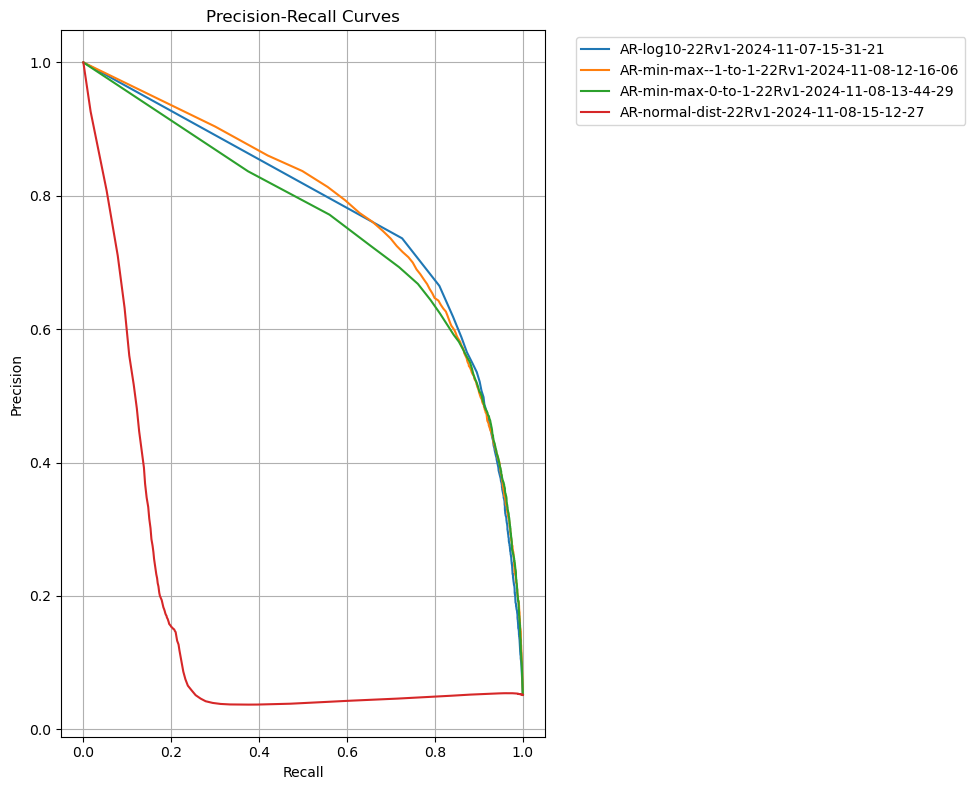

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create precision-recall curves for all prefixes
plt.figure(figsize=(10, 8))

for prefix in prefixes:
    df = dataframes[prefix]
    
    # Calculate precision and recall for many thresholds
    thresholds = np.linspace(0, 1, 1000)
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        tp = ((df['probabilities'] >= threshold) & (df['targets'] == 1)).sum()
        fp = ((df['probabilities'] >= threshold) & (df['targets'] == 0)).sum()
        fn = ((df['probabilities'] < threshold) & (df['targets'] == 1)).sum()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        precisions.append(precision)
        recalls.append(recall)
    
    # Plot precision-recall curve for this prefix
    plt.plot(recalls, precisions, label=prefix)

plt.xlabel('Recall')
plt.ylabel('Precision') 
plt.title('Precision-Recall Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()